In [2]:
import datacube
import sys
import xarray as xr
import pandas as pd
import numpy as np
from datacube.storage import masking
from skimage import exposure
import matplotlib.pyplot as plt

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_plotting import display_map


from skimage.color import rgb2hsv, hsv2rgb
from skimage.filters import unsharp_mask

def hsv_image_processing(rgb_array,
                         hue_mult=1, 
                         sat_mult=1, 
                         val_mult=1,
                         unsharp_radius=10, 
                         unsharp_amount=1):   
    
    # Convert to HSV and multiply bands
    hsv_array = rgb2hsv(rgb_array)
    hsv_array[:, :, 0] = hsv_array[:, :, 0] * hue_mult
    hsv_array[:, :, 1] = hsv_array[:, :, 1] * sat_mult
    hsv_array[:, :, 2] = hsv_array[:, :, 2] * val_mult
    
    # Apply unsharp mask to value band only
    hsv_array[:, :, 2] = unsharp_mask(image=hsv_array[:, :, 2], 
                                      radius=unsharp_radius, 
                                      amount=unsharp_amount)
    
    # Convert back to RGB
    return hsv2rgb(hsv_array)


/env/lib/python3.6/site-packages/datacube/storage/masking.py:8: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)
/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [16]:
# # East coast fires, tall
# upper_left = -27.7500, 152.0000
# lower_right = -30.8000, 155.2000
# time_range = ('2019-09-08', '2019-09-10')
# product = 's2a_nrt_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# resolution = (-50, 50)
# output_crs='EPSG:32756'
# percentile_stretch = (3, 97)
# log_transform = True

# # East coast fires, zoom Clarence
# upper_left = -29.380, 153.0776
# lower_right = -29.6510, 153.5308
# time_range = ('2019-09-08', '2019-09-10')
# product = 's2a_nrt_granule'
# bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-20, 20)
# output_crs='EPSG:32756'
# percentile_stretch = (1, 99)
# log_transform = False

# # East coast fires, zoom
# upper_left = -30.0000, 152.2360
# lower_right = -30.1800, 152.4000
# time_range = ('2019-09-08', '2019-09-10')
# product = 's2a_nrt_granule'
# bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-20, 20)
# output_crs='EPSG:32756'
# percentile_stretch = (0.5, 99.5)
# log_transform = False

# # East coast fires, Byfield
# upper_left = -21.4227, 149.7546
# lower_right = -23.000, 151.1000
# time_range = ('2019-09-08', '2019-09-10')
# product = 's2b_nrt_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# # bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-40, 40)
# output_crs='EPSG:32755'
# percentile_stretch = (2, 99.99)
# log_transform = True

# # East coast fires, Byfield zoom
# upper_left =  -22.4550, 150.520
# lower_right = -22.7350, 150.820
# time_range = ('2019-09-08', '2019-09-10')
# product = 's2b_nrt_granule'
# # bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-20, 20)
# output_crs='EPSG:32755'
# percentile_stretch = (1, 99)
# power = 0.8

# # East coast fires, zoom 14 Sep
# upper_left = -30.01, 152.30158
# lower_right = -30.15, 152.47084
# time_range = ('2019-09-13', '2019-09-15')
# product = 's2b_nrt_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# # bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-10, 10)
# output_crs='EPSG:32755'
# percentile_stretch = (1, 99)
# power = 0.3

# # NBART comparison
# upper_left = -37.07900, 145.07884
# lower_right = -37.21756, 145.27370
# time_range = ('2016-04-26', '2016-04-26')
# product = 's2a_ard_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# # bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-20, 20)
# output_crs='EPSG:32755'
# percentile_stretch = (0.5, 99.5)
# power = None

# # Forster fires, 2019
# upper_left = -29.1072, 151.3758
# lower_right = -29.365, 151.8352
# time_range = ('2019-11-11', '2019-11-11')
# product = 's2a_nrt_granule'
# # bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
# resolution = (-20, 20)
# output_crs='EPSG:32756'
# percentile_stretch = (5, 98.4)
# power = None

# # Canberra fire
# upper_left = -35.4597, 148.7372
# lower_right = -35.9473, 149.1809
# time_range = ('2020-02-03', '2020-02-05')
# product = 's2b_nrt_granule'
# # bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# bands = ['nbar_swir_3', 'nbar_swir_2', 'nbar_red']
# resolution = (-10, 10)
# output_crs='EPSG:32756'
# percentile_stretch = (0.2, 99.8)
# power = 0.5


# # Colour test
# upper_left = -28.47902, 153.12817
# lower_right = -28.88231, 153.65592
# time_range = ('2020-01-20', '2020-01-24')
# product = 's2b_nrt_granule'
# # bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# bands = ['nbart_swir_3', 'nbart_nir_2', 'nbart_red']
# resolution = (-50, 50)
# output_crs='EPSG:32756'
# percentile_stretch = (2, 98.4)
# power = None


# # Botany Bay
# upper_left =  -33.9342, 151.1111
# lower_right = -34.0595, 151.2935
# time_range = ('2020-02-10', '2020-02-12')
# product = 's2b_nrt_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# # bands = ['nbart_swir_3', 'nbart_nir_2', 'nbart_red']
# resolution = (-10, 10)
# output_crs='EPSG:32756'
# percentile_stretch = (1, 99)
# power = 0.5

# # Waragamba Dam
# upper_left = -34.08, 150.30413
# lower_right = -34.18823, 150.40936
# time_range = ('2020-02-19', '2020-02-19')
# product = 's2a_nrt_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# # bands = ['nbart_swir_3', 'nbart_nir_2', 'nbart_red']
# resolution = (-10, 10)
# output_crs='EPSG:32756'
# percentile_stretch = (0.5, 99.5)
# power = 1

# # Lake Carnagie
# upper_left =  -25.9245, 122.0678
# lower_right = -26.3399, 122.7669
# time_range = ('2020-02-15', '2020-02-19')
# product = 's2a_ard_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# resolution = (-10, 10)
# output_crs='EPSG:32751'
# percentile_stretch = (0.05, 99.65)
# power = 0.6


# Tasmania fires, 2016
upper_left = -41.22, 144.74
lower_right = -41.45, 145.26
time_range = ('2016-03-14', '2016-03-14')
product = 's2a_ard_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
resolution = (-10, 10)
output_crs='EPSG:32755'
percentile_stretch = (0.5, 99.5)
power = 0.8


upper_left = -19.80, 119.0
lower_right = -20.05, 119.5
time_range = ('2018-09-02', '2018-09-06')
product = 's2b_ard_granule'
bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
resolution = (-20, 20)
output_crs='EPSG:32750'
percentile_stretch = (0.5, 99.5)
power = 0.8


# Algae - Burley-Griffin
upper_left = -35.274, 149.0926
lower_right = -35.320, 149.1626
time_range = ('2021-03-05', '2021-03-05')
product = 's2a_nrt_granule'
bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
resolution = (-5, 5)
output_crs='EPSG:32756'
percentile_stretch = (1, 99)
power = 0.5

# Algae - Burundjuck
upper_left = -34.953, 148.57841
lower_right = -35.05, 148.722
time_range = ('2021-03-05', '2021-03-05')
product = 's2a_nrt_granule'
bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
resolution = (-5, 5)
output_crs='EPSG:32756'
percentile_stretch = (0.5, 99.5)
power = 0.9

upper_left =  -34.9013, 148.687
lower_right = -34.9801, 148.827
time_range = ('2021-03-05', '2021-03-05')
product = 's2a_nrt_granule'
bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
resolution = (-5, 5)
output_crs='EPSG:32756'
percentile_stretch = (0.5, 99.5)
power = 0.7




upper_left =  -33.52938, 150.67097
lower_right = -33.70692, 150.93533
time_range = ('2021-03-25', '2021-03-27')
product = 's2a_nrt_granule'
bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
resolution = (-10, 10)
output_crs='EPSG:32756'
percentile_stretch = (0.5, 99.5)
power = 0.7

upper_left =  -33.52938, 150.67097
lower_right = -33.70692, 150.93533
time_range = ('2021-03-14', '2021-03-16')
product = 's2a_nrt_granule'
# bands = ['nbar_red', 'nbar_green', 'nbar_blue']
bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
resolution = (-20, 20)
output_crs='EPSG:32756'
percentile_stretch = (1, 99)
power = 0.8


# Sediment examples
upper_left =  -29.34900, 153.26472
lower_right = -29.48131, 153.51407
time_range = ('2021-03-26', '2021-03-29')
product = 's2b_nrt_granule'
bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
resolution = (-10, 10)
output_crs='EPSG:32756'
percentile_stretch = (0.5, 99.5)
power = 0.7

upper_left =  -33.48268, 151.17537
lower_right = -33.70999, 151.57454
time_range = ('2021-03-26', '2021-03-29')
product = 's2b_nrt_granule'
bands = ['nbar_red', 'nbar_green', 'nbar_blue']
# bands = ['nbar_swir_3', 'nbar_nir_2', 'nbar_red']
resolution = (-10, 10)
output_crs='EPSG:32756'
percentile_stretch = (0.5, 99.5)
power = 0.7


# Plot area
display_map(y=(upper_left[0], lower_right[0]),
            x=(upper_left[1], lower_right[1]))

In [17]:
# Connect to the datacube
dc = datacube.Datacube(app='Sentinel2_plot')

# Load data
s2_data = dc.load(product=product,
                  measurements=bands,
                  y=(upper_left[0], lower_right[0]),
                  x=(upper_left[1], lower_right[1]),
                  time=time_range,
                  resolution=resolution,
                  output_crs=output_crs,
#                   resampling='cubic',
                  group_by='solar_day')

# Mask out nodata
s2_data = masking.mask_invalid_data(s2_data)

# Print output
print(s2_data)


<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*


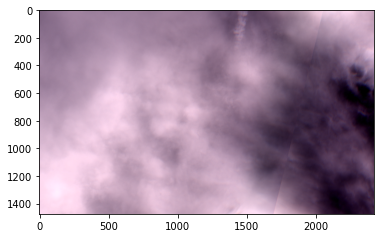

In [15]:
# Multiplier
mult = 1

# Convert to numpy array
rgb_array = np.transpose((s2_data.isel(time=0) * mult).to_array().values, axes=[1, 2, 0])

# Apply a log transform to improve colours
if power:
    rgb_array = rgb_array ** power

# Contrast stretching
p_low, p_high = np.nanpercentile(rgb_array, percentile_stretch)
rgb_rescaled = exposure.rescale_intensity(rgb_array.astype(np.float),
                                          in_range=(p_low, p_high),
                                          out_range=(0.0, 1.0))

# Apply coarse-scale unsharp masking
rgb_rescaled = hsv_image_processing(rgb_rescaled,
                                    unsharp_radius=150,
                                    unsharp_amount=0.3)

# HSV process
rgb_rescaled = hsv_image_processing(rgb_rescaled,
                                    val_mult=1.02,
                                    unsharp_radius=5,
                                    unsharp_amount=0.1)

# Plot RGB
plt.imshow(rgb_rescaled)

# Create unique file name
fname = f'{product[0:3]}_{time_range[0]}_{upper_left[0]:+.2f}_{upper_left[1]:.2f}_' \
        f'{lower_right[0]:+.2f}_{lower_right[1]:.2f}_{resolution[1]}m_nbar.jpg'

# Export to file
plt.imsave(fname=fname, arr=rgb_rescaled, format="jpg")
